In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import warnings
warnings.simplefilter(action='ignore')

# load data

In [94]:
orignalData=pd.read_csv('train.csv')
orignalData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# cleaning colums

In [95]:
orignalData.columns=orignalData.columns.str.strip().str.lower().str.replace(' ', '_')

# cleaning data 

In [96]:
print('null value summary',orignalData.isnull().sum())

null value summary passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64


In [106]:
# check percentage of null  and check concentration of age 
nullAgeData=orignalData[orignalData['age'].isnull()]
print('Null Age Percenatege ',len(nullAgeData)/len(orignalData)*100,'%')



Null Age Percenatege  19.865319865319865 %


finding avg age to fill null values

In [98]:
# mean age
print('The avg of "Age" is %.2f' %(orignalData["age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(orignalData["age"].median(skipna=True)))

The avg of "Age" is 29.70
The median of "Age" is 28.00


In [99]:
nullCabinData=orignalData[orignalData['cabin'].isnull()]
print('Percentage of missing cabin data',len(nullCabinData)/len(orignalData)*100,'%')
# 70 % of values are missing filling this info is not going to help lets drop this coloum

Percentage of missing cabin data 77.10437710437711 %


In [100]:
nullembarkeddata=orignalData[orignalData['embarked'].isnull()]
print('Percentage of missing embarked data',len(nullembarkeddata)/len(orignalData)*100,'%','empty records',len(nullembarkeddata))


print(orignalData['embarked'].value_counts())
# only 2 records are empty and majory of embarked are from S 

Percentage of missing embarked data 0.22446689113355783 % empty records 2
embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [101]:
cleanOrignalData=orignalData.copy()
cleanOrignalData.drop('cabin',axis=1,inplace=True)
cleanOrignalData['age']=cleanOrignalData['age'].fillna(28.00)
cleanOrignalData['embarked']=cleanOrignalData['embarked'].fillna('S')

In [102]:
cleanOrignalData.head(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


# Feature engg 

In [103]:
# check if user is traveling alone if subsp or patch is 0 then user is traveling alone
cleanOrignalData['is_alone'] =np.where(cleanOrignalData['sibsp'] + cleanOrignalData['parch'] == 0, 1, 0)
cleanOrignalData.drop(['sibsp','parch'],axis=1,inplace=True)
print(cleanOrignalData['is_alone'].value_counts())

is_alone
1    537
0    354
Name: count, dtype: int64


In [ ]:
# converting sex,pclass and embarked to each cloums with 1 or 0 to be used in model. creating categorical one hot encoded values
cleanOrignalData=pd.get_dummies(cleanOrignalData,columns=["pclass","embarked","sex"])
cleanOrignalData.drop(['name','ticket'],axis=1,inplace=True)

# exploring data

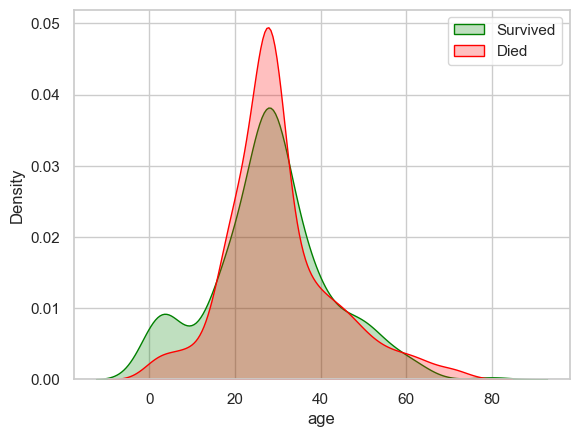

In [114]:
# checking age vs survior
sns.kdeplot(cleanOrignalData[cleanOrignalData['survived']==1]['age'],shade=True,color="green")
sns.kdeplot(cleanOrignalData[cleanOrignalData['survived']==0]['age'],shade=True,color="red")
plt.legend(['Survived', 'Died'])
plt.show()

we can see that lare surviours are below 16 from the graph. based on this we can create one more feature Is Minor based on age

In [116]:
cleanOrignalData['is_minor']=np.where(cleanOrignalData['age']<18,1,0)

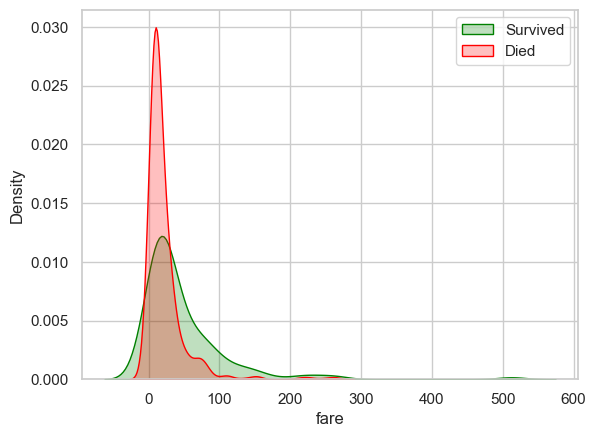

In [118]:
#check age vs fare
 
sns.kdeplot(cleanOrignalData[cleanOrignalData['survived']==1]['fare'],shade=True,color="green")
sns.kdeplot(cleanOrignalData[cleanOrignalData['survived']==0]['fare'],shade=True,color="red")
plt.legend(['Survived', 'Died'])
plt.show()

 based on graph we can see large number of people died in low fare zone

In [129]:
cleanOrignalData.head(1)

,passengerid,survived,name,age,ticket,fare,is_alone,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,is_minor
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.25,0,False,False,True,False,False,True,False,True,0


# Modeling

In [131]:
# define features from model and creating X and Y variables
cols = ["age","fare","is_alone","pclass_1","pclass_2","pclass_3","embarked_C","embarked_Q","embarked_S","sex_female","sex_male","is_minor"] 
X = cleanOrignalData[cols]
Y = cleanOrignalData['survived']

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

intiating model traing

1. fit() returns the trained model object, not the predictions.
2. We need to wrap your LogisticRegression() inside the RFE selector to actually perform the attribute selection you mentioned.

In [ ]:
# 1. Define the base model
model = LogisticRegression()
# 2. Create the RFE selector
rfe = RFE(estimator=model, n_features_to_select=8)
# 3. Fit RFE to the training data
rfe.fit(x_train, y_train)
# Now that the rfe object is trained and knows which 8 features are best, we use it to predict the outcomes for your test set (x_test).

,"estimator estimator: ``Estimator`` instanceA supervised learning estimator with a ``fit`` method that providesinformation about feature importance(e.g. `coef_`, `feature_importances_`).",LogisticRegression()
,"n_features_to_select n_features_to_select: int or float, default=NoneThe number of features to select. If `None`, half of the features areselected. If integer, the parameter is the absolute number of featuresto select. If float between 0 and 1, it is the fraction of features toselect... versionchanged:: 0.24 Added float values for fractions.",8
,"step step: int or float, default=1If greater than or equal to 1, then ``step`` corresponds to the(integer) number of features to remove at each iteration.If within (0.0, 1.0), then ``step`` corresponds to the percentage(rounded down) of features to remove at each iteration.",1
,"verbose verbose: int, default=0Controls verbosity of output.",0
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a `coef_`or `feature_importances_` attributes of estimator.Also accepts a string that specifies an attribute name/pathfor extracting feature importance (implemented with `attrgetter`).For example, give `regressor_.coef_` in case of:class:`~sklearn.compose.TransformedTargetRegressor` or`named_steps.clf.feature_importances_` in case ofclass:`~sklearn.pipeline.Pipeline` with its last step named `clf`.If `callable`, overrides the default feature importance getter.The callable is passed with the fitted estimator and it shouldreturn importance for each feature... versionadded:: 0.24",'auto'
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True


In [154]:
# 4. Predict using the RFE model
y_pred = rfe.predict(x_test)

,age,fare,is_alone,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,is_minor
841,16.0,10.5000,1,False,True,False,False,False,True,False,True,1
167,45.0,27.9000,0,False,False,True,False,False,True,True,False,0
242,29.0,10.5000,1,False,True,False,False,False,True,False,True,0
55,28.0,35.5000,1,True,False,False,False,False,True,False,True,0
23,28.0,35.5000,1,True,False,False,False,False,True,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
244,30.0,7.2250,1,False,False,True,True,False,False,False,True,0
265,36.0,10.5000,1,False,True,False,False,False,True,False,True,0
463,48.0,13.0000,1,False,True,False,False,False,True,False,True,0
218,32.0,76.2917,1,True,False,False,True,False,False,True,False,0


In [ ]:
# Generate the matrix
# y_test = actual values, y_pred = predicted values from RFE
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
# .ravel() flattens the 2x2 matrix into a single line
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 92
False Positives: 8
False Negatives: 19
True Positives: 60


# checking with test csv

In [205]:
testing_data=pd.read_csv('test.csv')
testing_data.columns=testing_data.columns.str.strip().str.lower().str.replace(' ', '_')
testing_data.drop('cabin',axis=1,inplace=True)
testing_data['age']=testing_data['age'].fillna(28.00)
testing_data['embarked']=testing_data['embarked'].fillna('S')

In [206]:
testing_data['is_alone'] =np.where(testing_data['sibsp'] + testing_data['parch'] == 0, 1, 0)
testing_data.drop(['sibsp','parch'],axis=1,inplace=True)

In [207]:
testing_data=pd.get_dummies(testing_data,columns=["pclass","embarked","sex"])
testing_data.drop(['name','ticket'],axis=1,inplace=True)

In [208]:
testing_data['is_minor']=np.where(testing_data['age']<18,1,0)

In [210]:
testing_data.drop(['passengerid'],axis=1,inplace=True)

In [214]:
testing_data.dropna(subset=['fare'], inplace=True)

In [215]:
testing_data.isnull().sum()

age           0
fare          0
is_alone      0
pclass_1      0
pclass_2      0
pclass_3      0
embarked_C    0
embarked_Q    0
embarked_S    0
sex_female    0
sex_male      0
is_minor      0
dtype: int64

In [217]:
count={'Survived':0,'Not Survived':0}
for index,value in testing_data.iterrows():
    res = rfe.predict([value])
    if res[0]==0:
        count['Survived']+=1
    else:
        count['Not Survived']+=1
print(count)   
     

{'Survived': 280, 'Not Survived': 137}
